In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pickle
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn import model_selection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#downloading models with best parameters 
with open('/content/drive/Shareddrives/SignLanguageData/FinalSVM.pkl','rb') as f:
  svm = pickle.load(f)

with open('/content/drive/Shareddrives/SignLanguageData/FinalXGB.pkl','rb') as f:
  xgb = pickle.load(f)

with open('/content/drive/Shareddrives/SignLanguageData/lr_model.pkl','rb') as f:
  lr = pickle.load(f) 

with open('/content/drive/Shareddrives/SignLanguageData/rfc_model.pkl','rb') as f:
  rf = pickle.load(f)



In [8]:
# Load the augmented data from the file
data = np.load('/content/drive/Shareddrives/SignLanguageData/combined_features_pca_lda.npz')
#unpacking 
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 53)
y_train Shape: (109820,)
X_test Shape: (28688, 53)
y_test Shape: (28688,)


In [ ]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)


GaussianNB()

In [4]:
all_estimators = [
    ('svm',SVC(kernel = 'poly', gamma = 'auto', C = .1, probability=True)),
    ('xgb',xgb.XGBClassifier(subsample=0.4,reg_lambda=2.25,reg_alpha=2,min_child_weight=30,max_depth=8,learning_rate=0.001,gamma=0,colsample_bytree=0.4)),
    ('lr',LogisticRegression(C=0.22564631610840102,max_iter=2391, penalty="l2", solver='newton-cg',warm_start=False)),
    ('rf',RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5,max_features=5, max_depth=5, random_state=42))
]

In [12]:
models = {'Naive Bayes':GaussianNB(),
          'Logistic Regression':LogisticRegression(C=0.22564631610840102,max_iter=2391, penalty="l2",solver='newton-cg',warm_start=False),
          'SVM':SVC(kernel = 'poly', gamma = 'auto', C = .1, probability=True),
          'Random Forest Classifier':RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5,max_features=5, max_depth=5, random_state=42),
          'XGBoost':xgb.XGBClassifier(subsample=0.4,reg_lambda=2.25,reg_alpha=2,min_child_weight=30,max_depth=8,learning_rate=0.001,gamma=0,colsample_bytree=0.4)}



In [6]:
#function for sampling
def sampler(X,y,num_sample):
  indices = np.random.choice(X.shape[0], num_sample, replace=False)
  return X[indices,:],y[indices]

In [12]:
X_train_sample,y_train_sample = sampler(X_train,y_train,50000)
X_test_sample,y_test_sample = sampler(X_test,y_test,10000)

In [15]:
results = []
names = []

for name,model in models.items():
  kfold = model_selection.KFold(n_splits=5,random_state=99,shuffle=True)
  if name != 'XGBoost':
    cv_results = model_selection.cross_val_score(model,X_train_sample,y_train_sample,cv=kfold,scoring='accuracy')
  else:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y_train_sample)
    y_train_encoded = le.transform(y_train_sample)
    cv_results = model_selection.cross_val_score(model,X_train_sample,y_train_encoded,cv=kfold,scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  print(f'{name}: {cv_results.mean()}, {cv_results.std()}')


Naive Bayes: 0.6845, 0.005871541535235851
Logistic Regression: 0.7591000000000001, 0.005544366510251649
SVM: 0.718, 0.005106368572674732
Random Forest Classifier: 0.5319499999999999, 0.007483982896827067
XGBoost: 0.5713999999999999, 0.004223742416388586


In [5]:
models = {'Stacking Classifier':StackingClassifier(estimators=all_estimators, final_estimator=LogisticRegression(max_iter=3000))}


In [9]:
X_train_sample,y_train_sample = sampler(X_train,y_train,20000)
X_test_sample,y_test_sample = sampler(X_test,y_test,5000)

In [10]:
results = []
names = []

for name,model in models.items():
  kfold = model_selection.KFold(n_splits=5,random_state=99,shuffle=True)
  if name != 'XGBoost':
    cv_results = model_selection.cross_val_score(model,X_train_sample,y_train_sample,cv=kfold,scoring='accuracy')
  else:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y_train_sample)
    y_train_encoded = le.transform(y_train_sample)
    cv_results = model_selection.cross_val_score(model,X_train_sample,y_train_encoded,cv=kfold,scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  print(f'{name}: {cv_results.mean()}, {cv_results.std()}')


Stacking Classifier: 0.835, 0.005985398900658153


In [13]:
results_stacking = results

In [17]:
test = results

In [18]:
test.append(results_stacking)

In [21]:
names.append('Stacking Classifier')

In [22]:
names

['Naive Bayes',
 'Logistic Regression',
 'SVM',
 'Random Forest Classifier',
 'XGBoost',
 'Stacking Classifier']

In [23]:
test

[array([0.6915 , 0.674  , 0.6835 , 0.68575, 0.68775]),
 array([0.76325, 0.75425, 0.75525, 0.75475, 0.768  ]),
 array([0.7225 , 0.71375, 0.714  , 0.714  , 0.72575]),
 array([0.533  , 0.525  , 0.528  , 0.52775, 0.546  ]),
 array([0.57625, 0.56625, 0.5675 , 0.57075, 0.57625]),
 [array([0.83975, 0.831  , 0.835  , 0.82625, 0.843  ])]]

In [28]:
test.pop()

[array([0.83975, 0.831  , 0.835  , 0.82625, 0.843  ])]

In [29]:
test.append(results_stacking[0])

In [30]:
test

[array([0.6915 , 0.674  , 0.6835 , 0.68575, 0.68775]),
 array([0.76325, 0.75425, 0.75525, 0.75475, 0.768  ]),
 array([0.7225 , 0.71375, 0.714  , 0.714  , 0.72575]),
 array([0.533  , 0.525  , 0.528  , 0.52775, 0.546  ]),
 array([0.57625, 0.56625, 0.5675 , 0.57075, 0.57625]),
 array([0.83975, 0.831  , 0.835  , 0.82625, 0.843  ])]

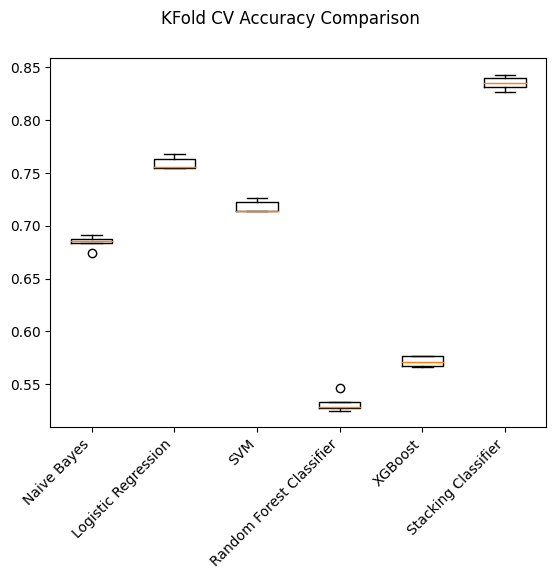

In [33]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('KFold CV Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(test)
ax.set_xticklabels(names)
plt.xticks(rotation=45, ha='right')
plt.show()